In [1]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import warnings
#Optimization
from scipy.optimize import minimize
start_date='2015-04-01'
end_date='2023-4-23'
df_nv=yf.download('NVDA',start=start_date,end=end_date)
df_ap=yf.download('AAPL',start=start_date,end=end_date)
df_ms=yf.download('MSFT',start=start_date,end=end_date)
df_goo=yf.download('GOOGL',start=start_date,end=end_date)
df_amz=yf.download('AMZN',start=start_date,end=end_date)
df_lr=yf.download('LRCX',start=start_date,end=end_date)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [2]:
def rolling_above(df,ma):
    # suppress all warnings
    warnings.filterwarnings("ignore")
    price=df[['Adj Close']]
    MA='MA{}'.format(str(ma))
    price[MA]=price['Adj Close'].rolling(window=int(ma)).mean()
    price=price.dropna()
    price['Position']=np.where(price[MA]<price['Adj Close'],1,-1)
    detect=price['Position'].diff()
    price['Return']=np.log(price['Adj Close']/
                           price['Adj Close'].shift(1))
    price['Strategy']=price['Return'].shift(1)*price['Position']
    price.dropna(inplace=True)
    ret=np.exp(price[['Strategy']].sum())
    warnings.filterwarnings("default")
    return ret
# define the initial guess
x0 = [200]
# define the bounds for the input variables
bound = [(180, 230)]
# integer constraint
def integer_constraint(x):
    # custom constraint function that checks if the input variable is an integer
    return np.round(x) - x
constraints = [{'type': 'ineq', 'fun': integer_constraint}]

In [3]:
res_ms2 = minimize(lambda x: rolling_above(df_ms,x),x0, method='SLSQP',
               bounds=bound, constraints=constraints)

print("MSFT Optimized values:", res_ms2.x)
print("Function value:", res_ms2.fun)

MSFT Optimized values: [200.]
Function value: 13.97571379789825


In [4]:
res_nv2 = minimize(lambda x: rolling_above(df_nv,x),x0, method='SLSQP',
               bounds=bound, constraints=constraints)

print("NVDA Optimized values:", res_nv2.x)
print("Function value:", res_nv2.fun)

NVDA Optimized values: [200.]
Function value: 349.52307104484316


In [6]:
def rolling_above_strat_order_num(df,tic,ma):
    # suppress all warnings
    warnings.filterwarnings("ignore")
    price=df[['Adj Close']]
    price=price.rename(columns={'Adj Close':tic})
    MA='MA{}'.format(str(ma))
    price[MA]=price[tic].rolling(window=int(ma)).mean()
    price=price.dropna()
    price['Position']=np.where(price[MA]<price[tic],1,0)
    detect=price['Position'].diff()
    buy_indices=price.index[detect>0].to_list()
    price['Return']=np.log(price[tic]/price[tic].shift(1))
    price['Strategy']=price['Return'].shift(1)*price['Position']
    price.dropna(inplace=True)
    ret=np.exp(price[['Strategy']].sum())[0]
    no_strat=np.exp(price[['Return']].sum())[0]
    return len(buy_indices),ret,no_strat
    warnings.filterwarnings("default")
days=np.arange(150,240,10)
dfs=[df_nv,df_ap,df_ms,df_goo,df_amz,df_lr]
tics=['NVDA','AAPL','MSFT','GOOGL','AMZN','LRCX']

In [7]:
def rolling_above_plot(df,tic,ma):
    # suppress all warnings
    warnings.filterwarnings("ignore")
    price=df[['Adj Close']]
    price=price.rename(columns={'Adj Close':tic})
    MA='MA{}'.format(str(ma))
    price[MA]=price[tic].rolling(window=int(ma)).mean()
    price=price.dropna()
    price['Position']=np.where(price[MA]<price[tic],1,0)
    detect=price['Position'].diff()
    buy_indices=price.index[detect>0].to_list()
    print('Buy at ',buy_indices)
    sell_indices=price.index[detect<0].to_list()
    print('Total number of orders made ',len(sell_indices))
    ax = price.plot(secondary_y='Position', figsize=(10, 6))
    ax.get_legend().set_bbox_to_anchor((0.25, 0.85))
    price['Return']=np.log(price[tic]/price[tic].shift(1))
    price['Strategy']=price['Return'].shift(1)*price['Position']
    price.dropna(inplace=True)
    ret=np.exp(price[['Return','Strategy']].sum())
    print(ret)
    warnings.filterwarnings("default")

Here we go  NVDA
Buy at  [Timestamp('2018-10-12 00:00:00'), Timestamp('2018-10-16 00:00:00'), Timestamp('2019-09-04 00:00:00'), Timestamp('2020-03-17 00:00:00'), Timestamp('2021-03-09 00:00:00'), Timestamp('2022-03-09 00:00:00'), Timestamp('2022-03-15 00:00:00'), Timestamp('2023-01-17 00:00:00'), Timestamp('2023-01-20 00:00:00')]
Total number of orders made  9
Return      33.795936
Strategy    78.709550
dtype: float64
Here we go  AAPL
Buy at  [Timestamp('2016-07-28 00:00:00'), Timestamp('2018-02-09 00:00:00'), Timestamp('2018-04-30 00:00:00'), Timestamp('2018-11-15 00:00:00'), Timestamp('2019-03-18 00:00:00'), Timestamp('2019-03-20 00:00:00'), Timestamp('2019-03-28 00:00:00'), Timestamp('2019-05-15 00:00:00'), Timestamp('2019-06-07 00:00:00'), Timestamp('2020-03-24 00:00:00'), Timestamp('2020-04-02 00:00:00'), Timestamp('2020-04-06 00:00:00'), Timestamp('2022-07-28 00:00:00'), Timestamp('2022-09-12 00:00:00'), Timestamp('2023-02-02 00:00:00'), Timestamp('2023-02-23 00:00:00'), Timestam

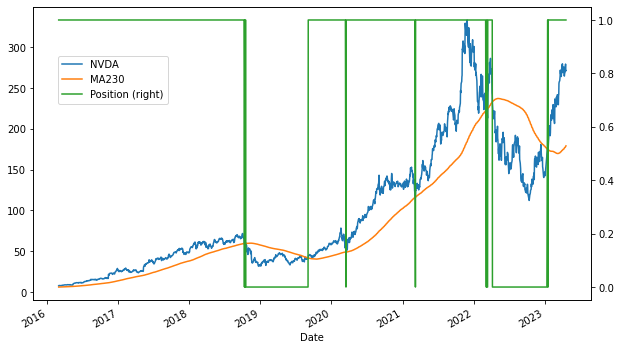

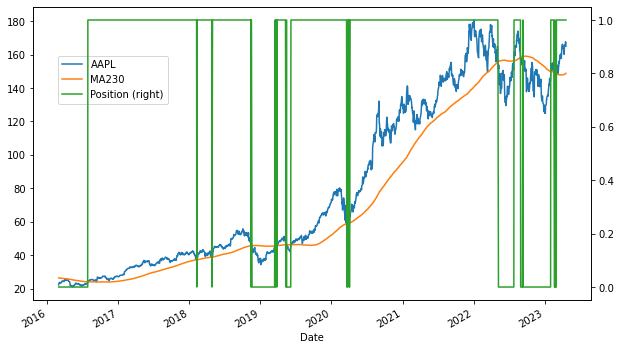

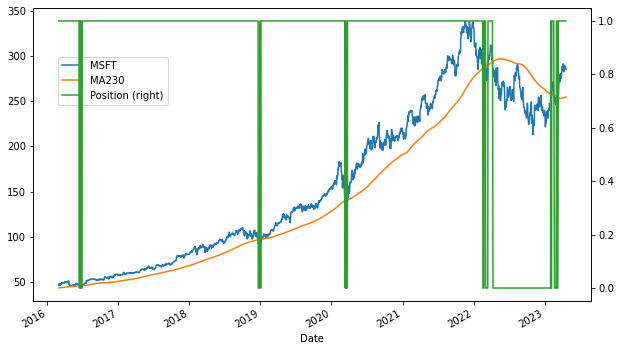

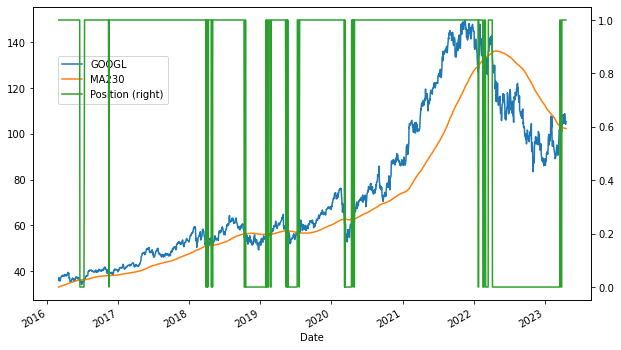

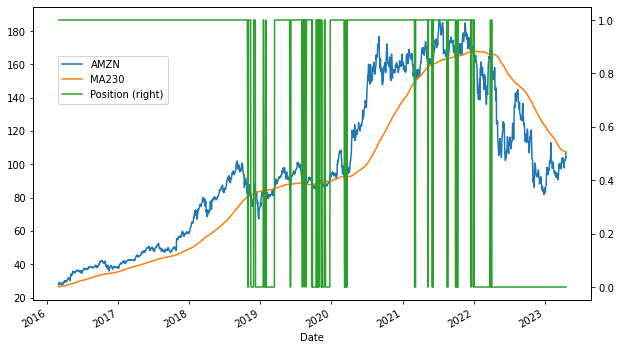

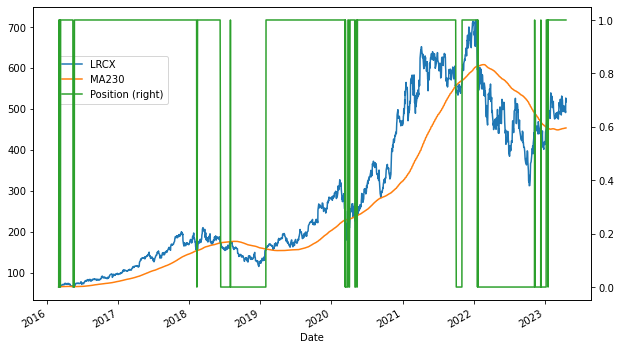

In [8]:
for df,tic in zip(dfs,tics):
    print('Here we go ',tic)
    rolling_above_plot(df,tic,230)

In [9]:
for df,tic in zip(dfs,tics):
    best_ct=1000
    best_ret=0
    best_day_ct=0
    best_ret_ct=0
    best_day_ret=0
    no_strat_ret=0
    print('Here we go ',tic)
    for day in days:
        cnt,ret,no_strat=rolling_above_strat_order_num(df,tic,day)
        if cnt<best_ct:
            best_ct=cnt
            best_day_ct=day
            best_ret_ct=ret
        if ret>best_ret:
            best_ret=ret
            best_day_ret=day
            no_strat_ret=no_strat
    print('Best MA to choose for ',tic,' to minimize order number is ',best_day_ct)
    print('Its order number is ',best_ct,' and its return is ',best_ret_ct)
    print('Best MA to choose for ',tic,' to maximize return is ',best_day_ret)
    print('Its return is ',best_ret,'. Comare it with ',no_strat_ret)

Here we go  NVDA
Best MA to choose for  NVDA  to minimize order number is  230
Its order number is  9  and its return is  78.7095504430504
Best MA to choose for  NVDA  to maximize return is  150
Its return is  300.3050754711282 . Comare it with  39.12517915767929
Here we go  AAPL
Best MA to choose for  AAPL  to minimize order number is  230
Its order number is  17  and its return is  11.848307890581493
Best MA to choose for  AAPL  to maximize return is  150
Its return is  17.998178653772218 . Comare it with  5.916710331790668
Here we go  MSFT
Best MA to choose for  MSFT  to minimize order number is  230
Its order number is  14  and its return is  9.029507980498085
Best MA to choose for  MSFT  to maximize return is  150
Its return is  9.97510505717779 . Comare it with  5.9406580299704075
Here we go  GOOGL
Best MA to choose for  GOOGL  to minimize order number is  160
Its order number is  22  and its return is  6.6697784077638556
Best MA to choose for  GOOGL  to maximize return is  150
I